In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'15j1Nou6m5WNLejJQrUcty6U03xsIgIAI'})
file_import.GetContentFile('SelfAttention.py') 

from SelfAttention import SelfAttention

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def single_category_regressor(features, context, context2, unitsNumber = 64):
    features = concatenate([features, context])
    
    dense_1 = Dense(unitsNumber, activation = 'elu')(features)
    dense_1_normalization = BatchNormalization()(dense_1)
    dense_1_dropout = Dropout(0.2)(dense_1_normalization)

    features = concatenate([dense_1_dropout, context2])

    dense_2 = Dense(unitsNumber, activation = 'elu')(features)
    dense_2_normalization = BatchNormalization()(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2_normalization)
    
    return Dense(1, activation='sigmoid')(dense_2_dropout)

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

embedding_dropout = SelfAttention()(embedding_dropout)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor(filtersNumber, features_3)


dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

single_category_layer = concatenate([
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 64),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 64),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 64),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 64),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 64),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 64),
])

output_layer = average([output_layer, single_category_layer])

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 20960/102124 [=====>........................] - ETA: 8:53 - loss: 0.1915 - acc: 0.9094 56992/102124 [===============>..............] - ETA: 4:41 - loss: 0.1230 - acc: 0.9459 93696/102124 [==========================>...] - ETA: 51s - loss: 0.1031 - acc: 0.9569102124/102124 [==============================] - 668s 7ms/step - loss: 0.1001 - acc: 0.9585 - val_loss: 0.0580 - val_acc: 0.9793
Epoch 2/32
 10432/102124 [==>...........................] - ETA: 9:14 - loss: 0.0671 - acc: 0.9758 54624/102124 [===============>..............] - ETA: 4:44 - loss: 0.0665 - acc: 0.9764 91072/102124 [=========================>....] - ETA: 1:06 - loss: 0.0644 - acc: 0.9770102124/102124 [==============================] - 651s 6ms/step - loss: 0.0637 - acc: 0.9773 - val_loss: 0.0962 - val_acc: 0.9728
roc-auc: 0.9247 - roc-auc_val: 0.9247                                                                                                    
Epoch 3/32

  1696/102124 [..............................] - ETA: 10:13 - loss: 0.0432 - acc: 0.9832 37056/102124 [=========>....................] - ETA: 6:32 - loss: 0.0401 - acc: 0.9841 72064/102124 [====================>.........] - ETA: 3:01 - loss: 0.0407 - acc: 0.9837102124/102124 [==============================] - 657s 6ms/step - loss: 0.0406 - acc: 0.9838 - val_loss: 0.0414 - val_acc: 0.9841
roc-auc: 0.9928 - roc-auc_val: 0.9871                                                                                                    
Epoch 19/32
  1216/102124 [..............................] - ETA: 10:12 - loss: 0.0358 - acc: 0.9862 37504/102124 [==========>...................] - ETA: 6:36 - loss: 0.0404 - acc: 0.9843 72736/102124 [====================>.........] - ETA: 2:59 - loss: 0.0407 - acc: 0.9839102124/102124 [==============================] - 662s 6ms/step - loss: 0.0405 - acc: 0.9840 - val_loss: 0.0407 - val_acc: 0.9843
Epoch 20/32
  2144/102124 [..............................] - ETA: 10

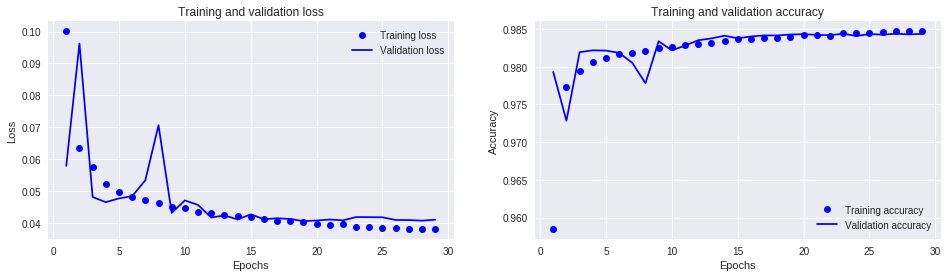

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 55s 2ms/step
([0.03906458965977606, 0.9845944820349818], 0.9890939342143611)
